In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%cd ..

/Users/kristophermiltiadou/Documents/UniWork/Cambridge/Thesis/CODE/iREC


In [32]:
# load modules
import torch
import torch.distributions as dist
import pickle as pkl
import matplotlib.pyplot as plt
from models.BayesianLinRegressor import BayesLinRegressor
from rec.utils import compute_variational_posterior
import seaborn as sns; sns.set(); sns.set_style('whitegrid')
import math
plt.rcParams.update({'font.weight': 'normal'})
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'lines.linewidth' : 2})
%config InlineBackend.figure_format='retina'

In [5]:
%matplotlib inline

In [6]:
def create_blr_problem(dim, seed, signal_std=1):
    
    initial_seed_target = seed
    blr = BayesLinRegressor(prior_mean=torch.zeros(dim),
                        prior_alpha=1,
                        signal_std=signal_std,
                        num_targets=10000,
                        seed=initial_seed_target)
    blr.sample_feature_inputs()
    blr.sample_regression_targets()
    blr.posterior_update()
    target = blr.weight_posterior
    return blr, target

In [7]:
def compute_preds(d, blr_obj):
    preds = torch.zeros([0])
    sample_list = torch.tensor(d['compressed_samples'])
    for s in sample_list:
        preds = torch.cat((preds, blr_obj.empirical_prediction(s)[None]))
    return preds

In [8]:
def true_preds(blr_obj):
    samples = blr_obj.weight_posterior.sample((50,))
    preds = torch.zeros([0])
    for s in samples:
        preds = torch.cat((preds, blr_obj.empirical_prediction(s)[None]))
    return preds

In [33]:
def var_approx_preds(blr_obj):
    samples = compute_variational_posterior(blr_obj.weight_posterior).sample((50,))
    preds = torch.zeros([0])
    for s in samples:
        preds = torch.cat((preds, blr_obj.empirical_prediction(s)[None]))
    return preds

# Point Estimate Results

## MSE

In [82]:
epsilons = [0., 0.05, 0.1, 0.15, 0.2]
dim = 20
beamwidth = 1
scheme = 'Variational'
emp_2d = []
hard = False
for eps in epsilons:
    emp_2d.append(pkl.load(open(f"PickledStuff/New_Exp/Dim{dim}/{scheme}_Epsilon{eps}_Beam{beamwidth}_Omega5{'_HARD' if hard else ''}.pkl", "rb")))

In [83]:
blr_seed = 1
signal_std = 1e-1 if hard else 1
b, t = create_blr_problem(dim=dim, seed=blr_seed, signal_std=signal_std)

In [84]:
signal_std

1

In [85]:
full_preds_2d = torch.zeros(len(epsilons), 50, len(b.regression_targets_test))
for i, _ in enumerate(epsilons):
    full_preds_2d[i] = compute_preds(emp_2d[i], b)

In [86]:
q = torch.tensor([0.25, 0.5, 0.75])
median_rmse = torch.quantile(torch.sqrt(torch.mean((full_preds_2d - b.regression_targets_test) ** 2, dim=2)), q, dim=1)
median_mae = torch.quantile(torch.mean(torch.abs(full_preds_2d - b.regression_targets_test), dim=2), q, dim=1)

In [87]:
mean_rmse_map = torch.sqrt(torch.mean((b.empirical_prediction(t.mean) - b.regression_targets_test) ** 2))

mean_mae_map = torch.mean(torch.abs(b.empirical_prediction(t.mean) - b.regression_targets_test))

In [88]:
def percentage_dropoff(stat, exact_stat, neg=False):
    if neg:
        diff = stat - exact_stat
        return 100 + (diff / exact_stat) * 100
    else:
        diff = stat - exact_stat
        return 100 - (diff / exact_stat) * 100

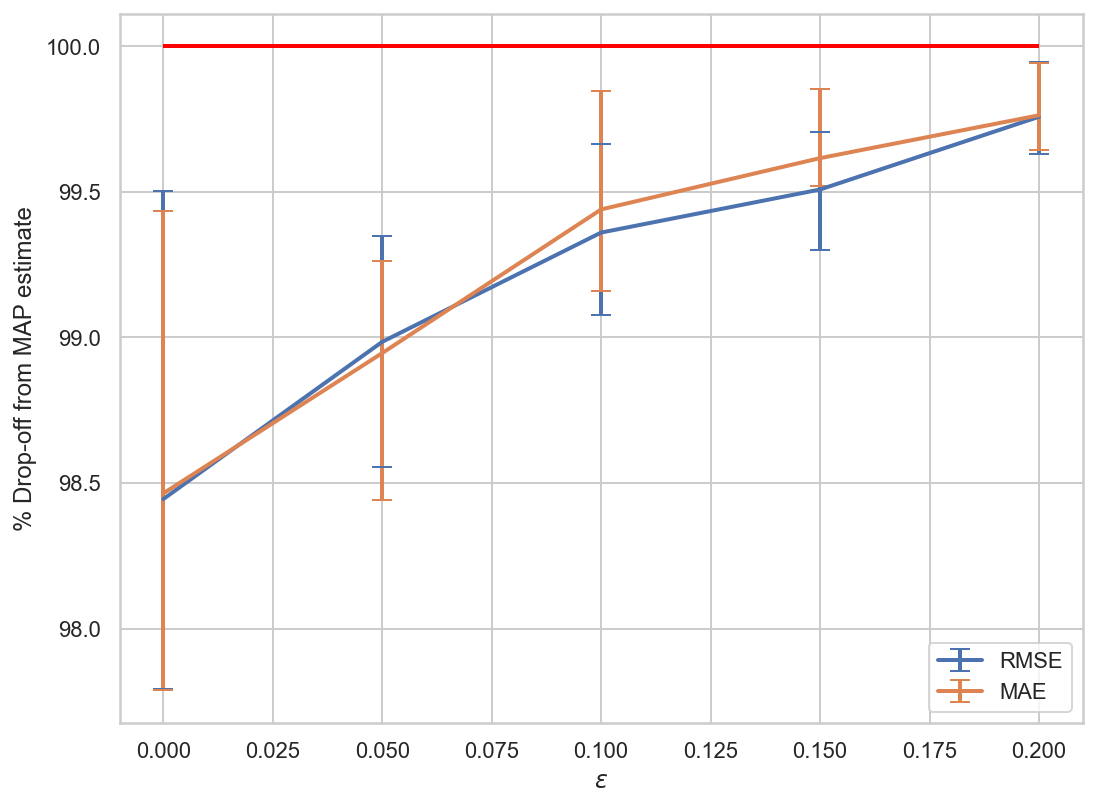

In [89]:
fig, ax = plt.subplots(1, figsize=(8,6))
ax.errorbar(epsilons, percentage_dropoff(median_rmse, mean_rmse_map)[1], capsize=5, 
            yerr= torch.abs(percentage_dropoff(median_rmse, mean_rmse_map) - percentage_dropoff(median_rmse, mean_rmse_map)[1])[[0, -1]], label='RMSE')
ax.errorbar(epsilons, percentage_dropoff(median_mae, mean_mae_map)[1], capsize=5,
            yerr= torch.abs(percentage_dropoff(median_mae, mean_mae_map) - percentage_dropoff(median_mae, mean_mae_map)[1])[[0, -1]], label='MAE')
ax.hlines(100, xmin=epsilons[0], xmax=epsilons[-1], color='red')
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel('% Drop-off from MAP estimate')
ax.legend(loc='lower right')
fig.tight_layout()

## Log-likelihood

In [63]:
log_likelihood_per_sample = torch.quantile(torch.sum(dist.normal.Normal(loc=full_preds_2d, scale=signal_std).log_prob(b.regression_targets_test), dim=2), q, dim=1)

In [64]:
map_log_likelihood = torch.sum(dist.normal.Normal(loc=b.empirical_prediction(t.mean), scale=signal_std).log_prob(b.regression_targets_test))

In [65]:
torch.sum(dist.normal.Normal(loc=b.empirical_prediction(b.true_sample), scale=1).log_prob(b.regression_targets_test))

tensor(-3575.3972)

In [66]:
map_log_likelihood

tensor(-3577.8164)

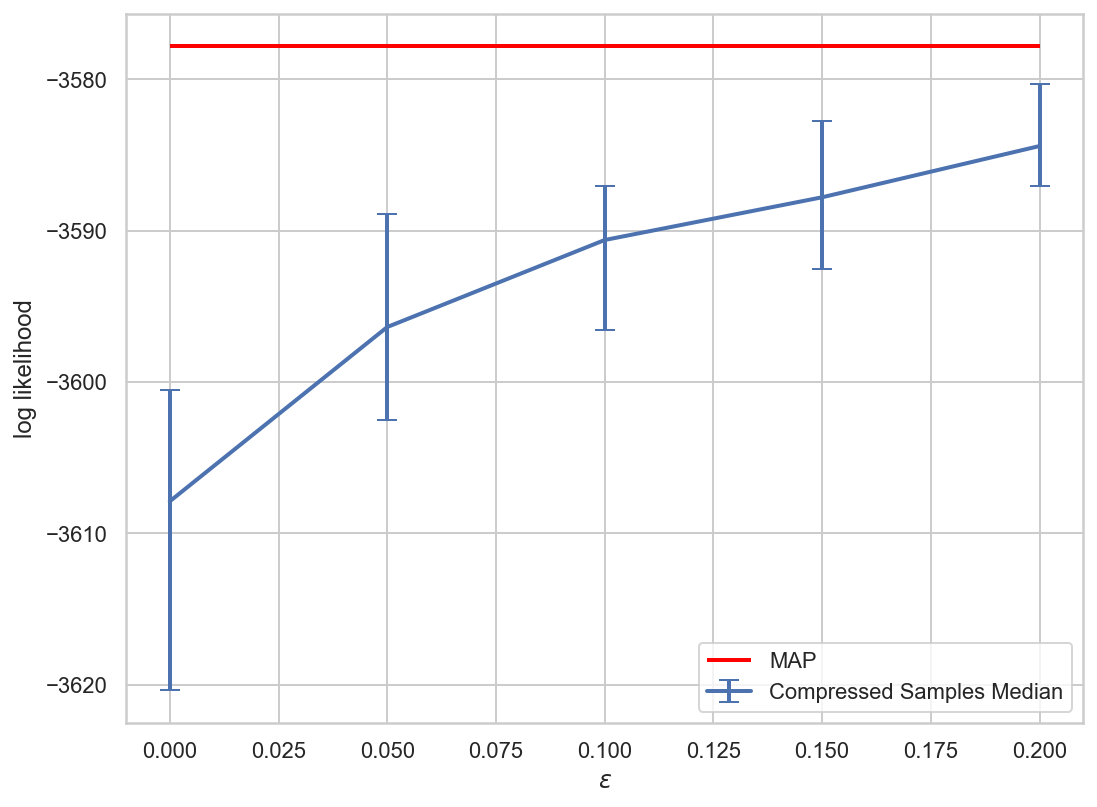

In [67]:
fig, ax = plt.subplots(1, figsize=(8,6))
error = log_likelihood_per_sample - log_likelihood_per_sample[1]
ax.errorbar(epsilons, log_likelihood_per_sample[1], capsize=5, 
            yerr = torch.abs(log_likelihood_per_sample - log_likelihood_per_sample[1])[[0, -1]], label='Compressed Samples Median')
ax.hlines(map_log_likelihood, xmin=epsilons[0], xmax=epsilons[-1], color='red', label='MAP')
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel('log likelihood')
ax.legend(loc='lower right')
fig.tight_layout()

# Considering Ensembles

## Log-likelihood

In [68]:
ensemble_preds = torch.mean(full_preds_2d, dim=1)

In [69]:
ensemble_log_likelihood = torch.sum(dist.normal.Normal(loc=ensemble_preds, scale=signal_std).log_prob(b.regression_targets_test), dim=1)

In [70]:
exact_ensemble = torch.mean(true_preds(b), dim=0)

In [71]:
exact_ensemble_likelihood = torch.sum(dist.normal.Normal(loc=exact_ensemble, scale=signal_std).log_prob(b.regression_targets_test))

In [72]:
exact_ensemble_var = torch.mean(var_approx_preds(b), dim=0)

In [73]:
exact_ensemble_likelihood_var = torch.sum(dist.normal.Normal(loc=exact_ensemble_var, scale=signal_std).log_prob(b.regression_targets_test))

In [74]:
full_predictive_mu, full_predictive_var = b.predictive_distribution(b.feature_targets_test)

In [75]:
full_predictive_dist = dist.normal.Normal(loc=full_predictive_mu, scale=torch.pow(full_predictive_var, 0.5))

In [76]:
full_likelihood = torch.sum(full_predictive_dist.log_prob(b.regression_targets_test))

In [77]:
full_likelihood

tensor(-3577.7505)

In [78]:
exact_ensemble_likelihood, exact_ensemble_likelihood_var

(tensor(-3577.2148), tensor(-3577.6670))

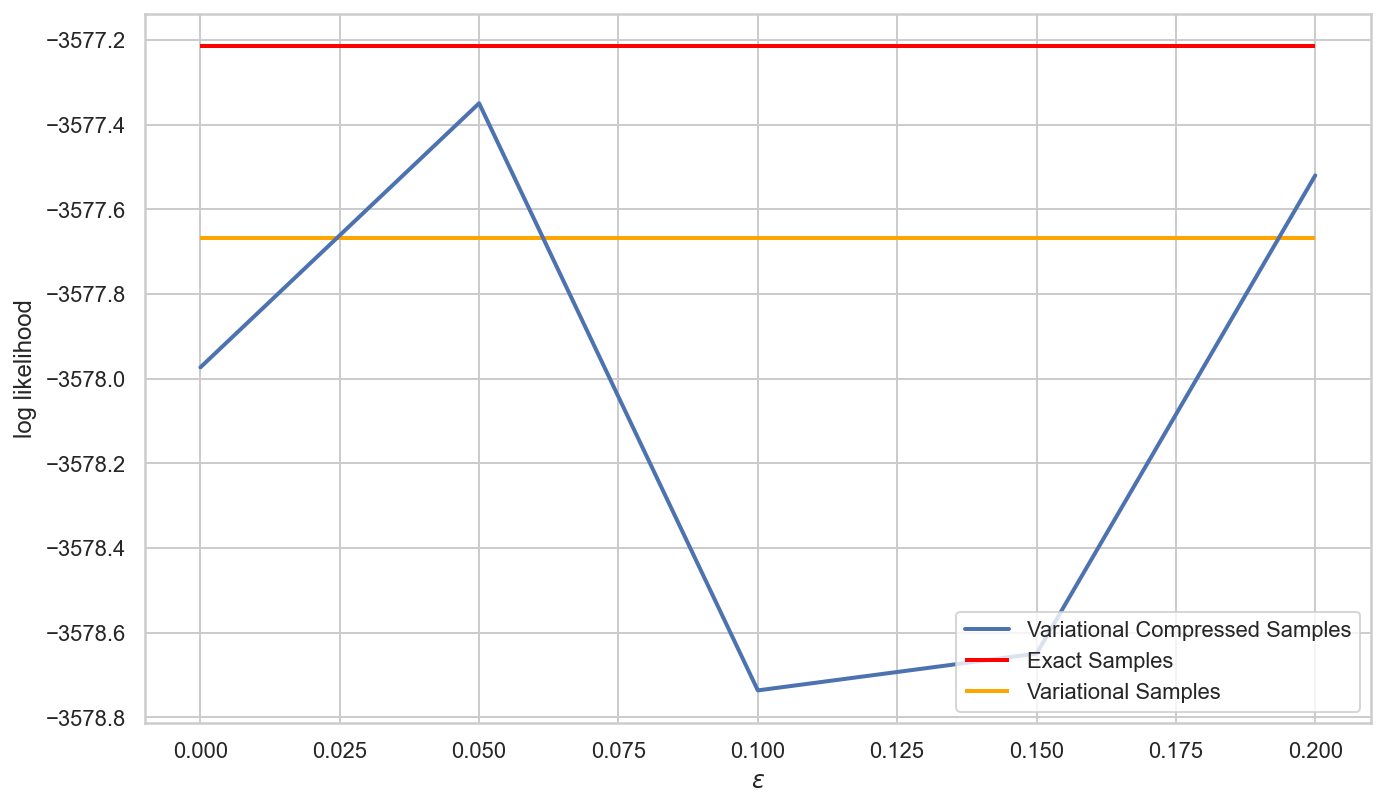

In [81]:
fig, ax = plt.subplots(1, figsize=(10,6))
ax.hlines(exact_ensemble_likelihood, xmin=epsilons[0], xmax=epsilons[-1], color='red', label='Exact Samples')
ax.hlines(exact_ensemble_likelihood_var, xmin=epsilons[0], xmax=epsilons[-1], color='orange', label='Variational Samples')
ax.plot(epsilons, ensemble_log_likelihood, label='Variational Compressed Samples')
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel('log likelihood')
ax.legend(loc='lower right')
fig.tight_layout()

RuntimeError: einsum() operands do not broadcast with remapped shapes [original->remapped]: [1000, 20]->[1000, 20] [1000, 2]->[1000, 2]

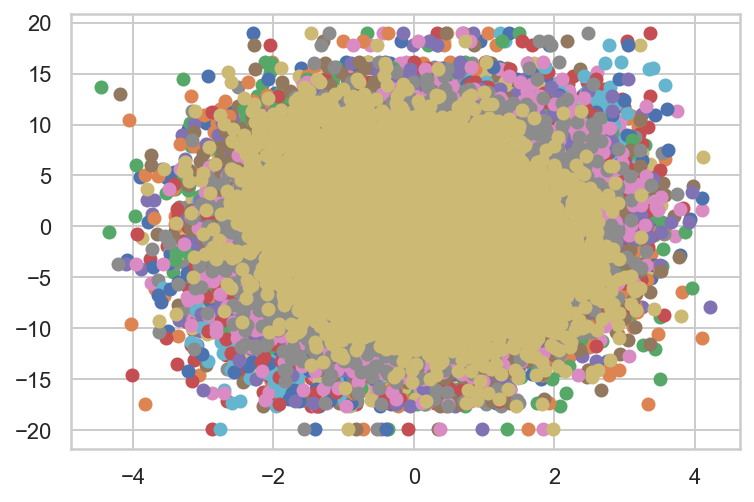

In [807]:
b.plot_regression_with_uncertainty(plot_samples=True)

In [ ]:
b.plot_sampled_regressor(t.mean)

## Absolute Performance

In [204]:
ensemble_mean_mse = torch.mean((torch.mean(full_preds_2d, dim=1) - b.regression_targets_test) ** 2, dim=1)

In [205]:
ensemble_mean_mae = torch.mean(torch.abs(torch.mean(full_preds_2d, dim=1) - b.regression_targets_test), dim=1)

In [206]:
ensemble_mse_exact = torch.mean((torch.mean(true_preds(b), dim=0) - b.regression_targets_test) ** 2)

In [207]:
ensemble_mae_exact = torch.mean(torch.abs(torch.mean(true_preds(b), dim=0) - b.regression_targets_test))

In [208]:
ensemble_mean_mae, ensemble_mean_mse, ensemble_mae_exact, ensemble_mse_exact

(tensor([0.7846, 0.7847, 0.7849, 0.7847, 0.7842]),
 tensor([0.9700, 0.9709, 0.9701, 0.9697, 0.9692]),
 tensor(0.7844),
 tensor(0.9696))

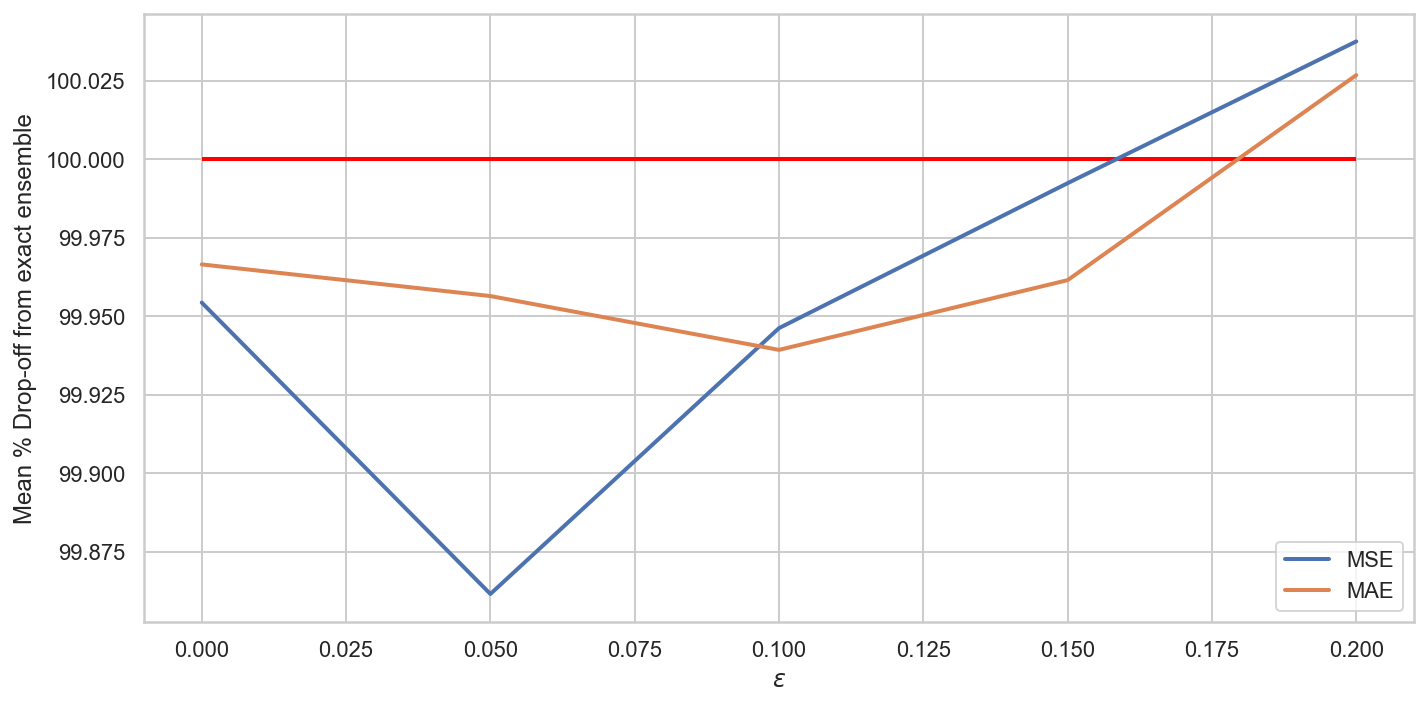

In [209]:
fig, ax = plt.subplots(1, figsize=(10,5))
ax.plot(epsilons, percentage_dropoff(ensemble_mean_mse, ensemble_mse_exact), label='MSE')
ax.plot(epsilons, percentage_dropoff(ensemble_mean_mae, ensemble_mae_exact), label='MAE')
ax.hlines(100, xmin=epsilons[0], xmax=epsilons[-1], color='red')
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel('Mean % Drop-off from exact ensemble')
ax.legend(loc='lower right')
fig.tight_layout()

## Standardised Performance

In [210]:
ensemble_mean_mse = torch.mean((torch.mean(full_preds_2d, dim=1) - b.regression_targets_test) ** 2 / torch.var(full_preds_2d, dim=1), dim=1)

In [211]:
ensemble_mean_mae = torch.mean(torch.abs(torch.mean(full_preds_2d, dim=1) - b.regression_targets_test) / torch.std(full_preds_2d, dim=1), dim=1)

In [212]:
ensemble_mse_exact = torch.mean((torch.mean(true_preds(b), dim=0) - b.regression_targets_test) ** 2 / torch.var(true_preds(b), dim=0))

In [213]:
ensemble_mae_exact = torch.mean(torch.abs(torch.mean(true_preds(b), dim=0) - b.regression_targets_test) / torch.std(true_preds(b), dim=0))

In [214]:
ensemble_mean_mae, ensemble_mean_mse, ensemble_mae_exact, ensemble_mse_exact

(tensor([ 8.3077,  9.5237, 10.5988, 11.0364, 11.7864]),
 tensor([114.3071, 152.3203, 188.7888, 206.0851, 234.0047]),
 tensor(23.0620),
 tensor(882.0703))

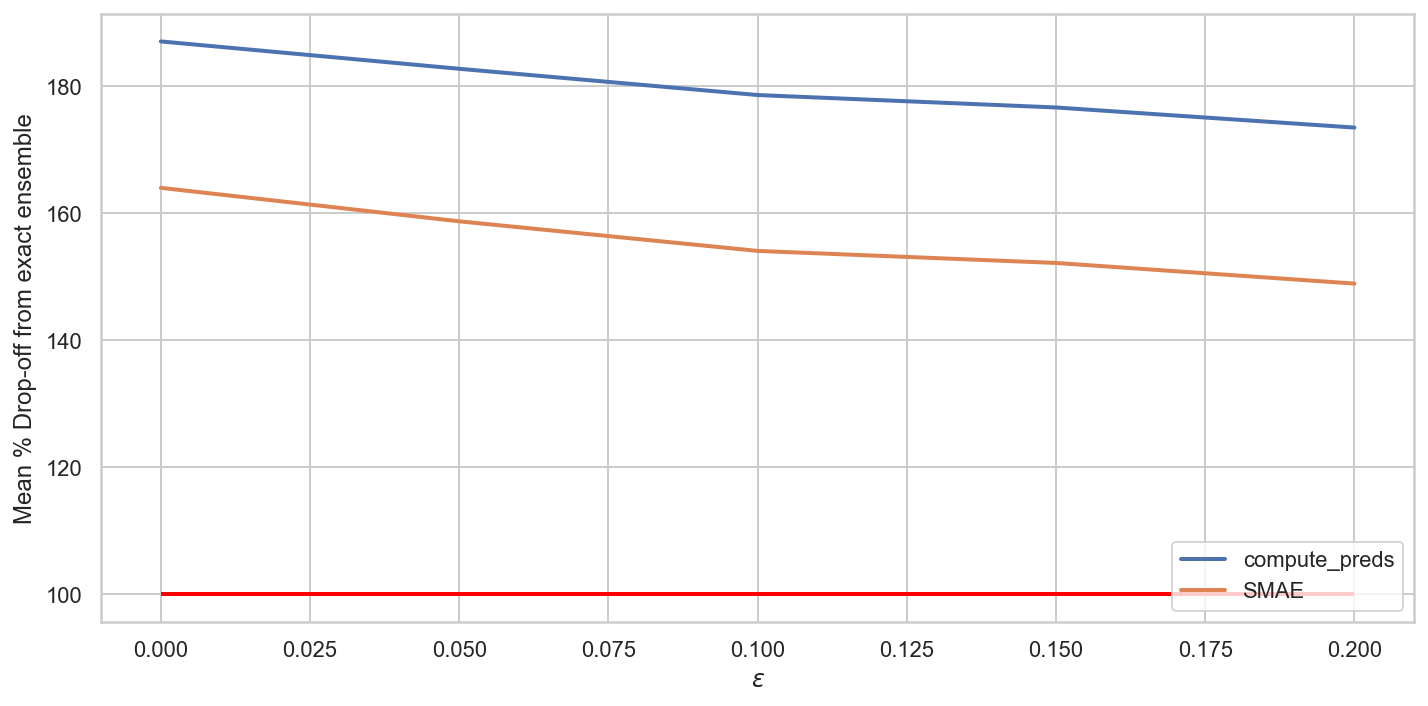

In [215]:
fig, ax = plt.subplots(1, figsize=(10,5))
ax.plot(epsilons, percentage_dropoff(ensemble_mean_mse, ensemble_mse_exact), label='compute_preds')
ax.plot(epsilons, percentage_dropoff(ensemble_mean_mae, ensemble_mae_exact), label='SMAE')
ax.hlines(100, xmin=epsilons[0], xmax=epsilons[-1], color='red')
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel('Mean % Drop-off from exact ensemble')
ax.legend(loc='lower right')
fig.tight_layout()

In [216]:
torch.mean(torch.var(true_preds(b), dim=0))

tensor(0.0013)

In [217]:
torch.mean(torch.var(full_preds_2d, dim=1), dim=1)

tensor([0.0104, 0.0081, 0.0066, 0.0061, 0.0053])